In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geobr
import folium

In this notebook, we plot our eBird observation data along with a regular rectangular grid of sites on a map of the Amazonas state of Brazil. We use this to select a subset of the sites on which to focus for our modeling and analysis.

Subsequently 

In [2]:
# Import the csv which contains a regular rectangular grid of sites across the Amazonas state, 
# marked by Latitude and Longitude
bird_sites = pd.read_csv('ebird_sites.csv')

In [63]:
# Quick modification to convert the 'observation_date' column of bird_sites to a datetime and also sort by datetime
bird_sites['observation_date'] = pd.to_datetime(bird_sites['observation_date'], format='%m/%d/%Y')
bird_sites = bird_sites.sort_values(by = 'observation_date')

In [8]:
am = geobr.read_state().loc[geobr.read_state().name_state == 'Amazonas']

In [6]:
# How many sites do we have in the dataframe
num_sites = len(bird_sites.Site_ID.unique())
# Make an array to hold the latitude and longitude for each site
sites_to_plot = np.zeros((num_sites,2))
i = 0
for site in bird_sites.Site_ID.unique():
    sites_to_plot[i,0] = bird_sites.loc[bird_sites.Site_ID == site].sample(1).X_coord.values[0]
    sites_to_plot[i,1] = bird_sites.loc[bird_sites.Site_ID == site].sample(1).Y_coord.values[0]
    i += 1

<Figure size 800x800 with 0 Axes>

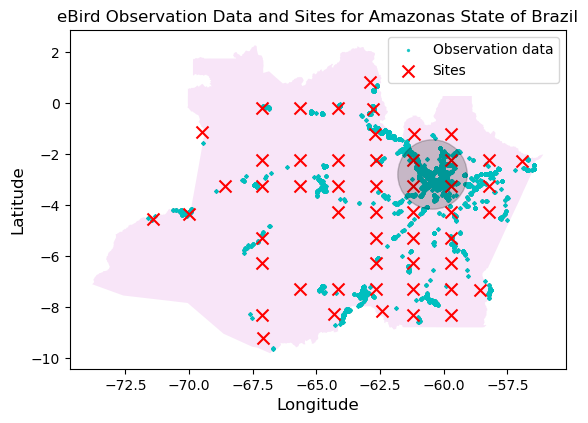

In [38]:
fig=plt.figure(figsize = (8,8))

# This plots the map of the Amazonas state
am.plot(alpha=0.1,color='m')

# Plot the eBird observation data
plt.scatter(x = bird_sites.longitude, y = bird_sites.latitude, 
            s = 2, alpha = 0.8, c='c', label='Observation data')

# Plot the sites
plt.scatter(sites_to_plot[:,0], sites_to_plot[:,1], s=75, c='r', marker = 'x', label = 'Sites')

# Highlight dense region of observations
plt.scatter(-60.45, -2.8, s=2500, c='k', marker = 'o', alpha=0.2 )

            
plt.xlabel('Longitude', fontsize = 12)
plt.ylabel('Latitude', fontsize = 12)
plt.title('eBird Observation Data and Sites for Amazonas State of Brazil')
plt.legend()
plt.show()

We see a very dense clustering of lots of observations within the gray-circled area. The four sites encompassed by this region thus stand out as prime candidates to use for data analysis. In our labeling of the sites, these four candidates are those with the Site_ID values: 68, 69, 78, 79.

Next we'll look in a little more detail at these sites to find some suitable species to study in greater detail. We would like to choose two species with distinct ecological roles so that our analysis might be able to highlight some differences between them. With this in mind, we will select one generalist species (a species capable of surviving in a variety of environmental conditions) and one forest specialist species (a species uniquely adapted to living in a forest environment).

We need to ensure, however, that our choices of species can provide us enough data on which to build robust models. So we need to ensure we have a large enough number of eBird 'checklists.' Checklists describe a particular observing run, i.e. a person or group of people went out to look for birds and reported all that they saw. Note that a single checklists can contain many species - a particular observer may have detected multiple species and not detected others. All of these are connected to the same checklist.

In the cell below we define a list of all our ecologically-motivated candidate species (a mixture of generalists and forest specialists). 

In [55]:
# Here is the full list of ecologically-motivated candidate species (a mixture of generalists and 
# forest specialists)
species = ['Arremon taciturnus', 'Bubulcus ibis', 'Bucco capensis',
           'Capito niger', 'Ceratopipra erythrocephala', 'Conopophaga aurita',
           'Crotophaga ani', 'Cyanocorax heilprini',
           'Euchrepomis spodioptila', 'Attila spadiceus',
           'Gymnopithys rufigula', 'Lipaugus vociferans',
           'Ramphastos tucanus', 'Rupornis magnirostris',
           'Thamnomanes caesius', 'Tinamus major', 'Trogon viridis',
           'Florisuga mellivora', 'Dendroplex picus', 'Thraupis palmarum',
           'Ramphocelus carbo', 'Pitangus sulphuratus', 'Cacicus cela',
           'Coragyps atratus']

In the cell below, we define a long-winded function to return the number of eBird checklists in each of our four sites of interest, at one of several specified frequency intervals.

In [57]:
# Function to see how many unique checklists (i.e. observing runs) we have for periods and sites at a 
# given frequency in the Amazonas state at our predetermined sites 68,69,78,79

def ebird_numchecks(df, species, year_start = 2015, year_stop = 2021, frequency = 'biannual'):
    """
    # df: dataframe from which to sample
    # species: scientific_name of species to select
    # sample_size: number of samples to draw
    # year_start: first year of interst
    # year_stop: last year of interst
    # sites: list of site (numbers) to consider
    # frequency: options are 'annual', 'biannual', 'quarterly', 'monthly'
    """
    years = np.arange(year_start, year_stop+1, 1)
    
    
    if frequency == 'annual':
        holder_arr = np.zeros((len(years), 5))
        col_names = ['year', 'checks_at_68', 'checks_at_69', 'checks_at_78', 'checks_at_79']
        i = 0 # year counter
        for year in years: # Loop through years
            criteria_68 = (df.scientific_name == species) & (df.Site_ID == 68) & (df.observation_date.dt.year == year)
            criteria_69 = (df.scientific_name == species) & (df.Site_ID == 69) & (df.observation_date.dt.year == year)                
            criteria_78 = (df.scientific_name == species) & (df.Site_ID == 78) & (df.observation_date.dt.year == year)
            criteria_79 = (df.scientific_name == species) & (df.Site_ID == 79) & (df.observation_date.dt.year == year)
            checks_68 = len(df.loc[criteria_68,'checklist_id'].unique())
            checks_69 = len(df.loc[criteria_69,'checklist_id'].unique())
            checks_78 = len(df.loc[criteria_78,'checklist_id'].unique())
            checks_79 = len(df.loc[criteria_79,'checklist_id'].unique())
            holder_arr[i,0] = year
            holder_arr[i,1] = checks_68
            holder_arr[i,2] = checks_69
            holder_arr[i,3] = checks_78
            holder_arr[i,4] = checks_79
            i += 1
        check_df = pd.DataFrame(holder_arr, columns = col_names)

    if frequency == 'biannual':
        half0 = [1,2,3,4,5,6]
        half1 = [7,8,9,10,11,12]
        sub = [half0, half1]
        holder_arr = np.zeros((len(years)*len(sub), 6))
        col_names = ['year', 'period', 'checks_at_68', 'checks_at_69', 'checks_at_78', 'checks_at_79']
        i = 0 # year counter
        for year in years: # Loop through years
            j = 0 # period counter
            for period in sub:
                criteria_68 = (df.scientific_name == species) & (df.Site_ID == 68) & (df.observation_date.dt.year == year) & (df.observation_date.dt.month.isin(period))
                criteria_69 = (df.scientific_name == species) & (df.Site_ID == 69) & (df.observation_date.dt.year == year) & (df.observation_date.dt.month.isin(period))
                criteria_78 = (df.scientific_name == species) & (df.Site_ID == 78) & (df.observation_date.dt.year == year) & (df.observation_date.dt.month.isin(period))
                criteria_79 = (df.scientific_name == species) & (df.Site_ID == 79) & (df.observation_date.dt.year == year) & (df.observation_date.dt.month.isin(period))
                checks_68 = len(df.loc[criteria_68,'checklist_id'].unique())
                checks_69 = len(df.loc[criteria_69,'checklist_id'].unique())
                checks_78 = len(df.loc[criteria_78,'checklist_id'].unique())
                checks_79 = len(df.loc[criteria_79,'checklist_id'].unique())
                holder_arr[i+j,0] = year
                holder_arr[i+j,1] = sub.index(period)
                holder_arr[i+j,2] = checks_68
                holder_arr[i+j,3] = checks_69
                holder_arr[i+j,4] = checks_78
                holder_arr[i+j,5] = checks_79
                j += 1
            i += j
        check_df = pd.DataFrame(holder_arr, columns = col_names)
        
    if frequency == 'quarterly':
        quarter0 = [1,2,3]
        quarter1 = [4,5,6]
        quarter2 = [7,8,9]
        quarter3 = [10,11,12]
        sub = [quarter0,quarter1,quarter2,quarter3]
        holder_arr = np.zeros((len(years)*len(sub), 6))
        col_names = ['year', 'period', 'checks_at_68', 'checks_at_69', 'checks_at_78', 'checks_at_79']
        i = 0 # year counter
        for year in years: # Loop through years
            j = 0 # period counter
            for period in sub:
                criteria_68 = (df.scientific_name == species) & (df.Site_ID == 68) & (df.observation_date.dt.year == year) & (df.observation_date.dt.month.isin(period))
                criteria_69 = (df.scientific_name == species) & (df.Site_ID == 69) & (df.observation_date.dt.year == year) & (df.observation_date.dt.month.isin(period))                    
                criteria_78 = (df.scientific_name == species) & (df.Site_ID == 78) & (df.observation_date.dt.year == year) & (df.observation_date.dt.month.isin(period))
                criteria_79 = (df.scientific_name == species) & (df.Site_ID == 79) & (df.observation_date.dt.year == year) & (df.observation_date.dt.month.isin(period))
                checks_68 = len(df.loc[criteria_68,'checklist_id'].unique())
                checks_69 = len(df.loc[criteria_69,'checklist_id'].unique())
                checks_78 = len(df.loc[criteria_78,'checklist_id'].unique())
                checks_79 = len(df.loc[criteria_79,'checklist_id'].unique())
                holder_arr[i+j,0] = year
                holder_arr[i+j,1] = sub.index(period)
                holder_arr[i+j,2] = checks_68
                holder_arr[i+j,3] = checks_69
                holder_arr[i+j,4] = checks_78
                holder_arr[i+j,5] = checks_79
                j += 1
            i += j
        check_df = pd.DataFrame(holder_arr, columns = col_names)
        
    if frequency == 'monthly':
        sub = [([month]) for month in range(1,13)]
        holder_arr = np.zeros((len(years)*len(sub), 6))
        col_names = ['year', 'period', 'checks_at_68', 'checks_at_69', 'checks_at_78', 'checks_at_79']
        i = 0 # year counter
        for year in years: # Loop through years
            j = 0 # period counter
            for period in sub:
                criteria_68 = (df.scientific_name == species) & (df.Site_ID == 68) & (df.observation_date.dt.year == year) & (df.observation_date.dt.month.isin(period))
                criteria_69 = (df.scientific_name == species) & (df.Site_ID == 69) & (df.observation_date.dt.year == year) & (df.observation_date.dt.month.isin(period))
                criteria_78 = (df.scientific_name == species) & (df.Site_ID == 78) & (df.observation_date.dt.year == year) & (df.observation_date.dt.month.isin(period))
                criteria_79 = (df.scientific_name == species) & (df.Site_ID == 79) & (df.observation_date.dt.year == year) & (df.observation_date.dt.month.isin(period))
                checks_68 = len(df.loc[criteria_68,'checklist_id'].unique())
                checks_69 = len(df.loc[criteria_69,'checklist_id'].unique())
                checks_78 = len(df.loc[criteria_78,'checklist_id'].unique())
                checks_79 = len(df.loc[criteria_79,'checklist_id'].unique())
                holder_arr[i+j,0] = year
                holder_arr[i+j,1] = sub.index(period)
                holder_arr[i+j,2] = checks_68
                holder_arr[i+j,3] = checks_69
                holder_arr[i+j,4] = checks_78
                holder_arr[i+j,5] = checks_79
                j += 1
            i += j
        check_df = pd.DataFrame(holder_arr, columns = col_names)

    return check_df

Below we show a plot comparing the number of checklists for a few different species at one of our sites. Most of the numbers and trends are fairly similar, so it isn't much help to plot all 24 of our species at once since so many of the points overlap. 

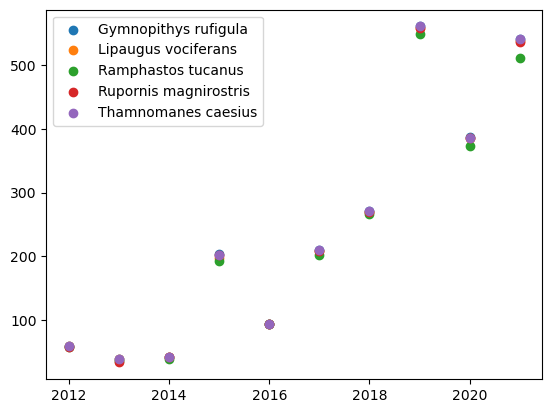

In [78]:
# Compare a few of the species for site 69
plt.figure()
for spec in species[10:15]:
    numchecks = ebird_numchecks(bird_sites, species = spec, year_start = 2012, year_stop = 2021, frequency = 'annual')
    plt.scatter(np.arange(2012,2022,1), numchecks.checks_at_69, label = spec)
plt.legend()
plt.show()
    

There aren't many bad candidates in terms of number of checklists (and thus amount of data) available to us - most of the species on our list are pretty similar in that regard. So we ultimately chose two species who seem to have a sufficient number of checklists associated with them and which we find interesting. These species are:

- Coragyps atratus (Black vulture) - a generalist
- Lipaugus vociferans (Screaming piha) - a forest specialist

Below we show the number of checklists associated with each of these species annually between 2012-2022

In [80]:
ebird_numchecks(bird_sites, species = 'Lipaugus vociferans', year_start = 2012, year_stop = 2021, frequency = 'annual')

,year,checks_at_68,checks_at_69,checks_at_78,checks_at_79
0,2012.0,3.0,60.0,28.0,33.0
1,2013.0,1.0,40.0,10.0,38.0
2,2014.0,2.0,42.0,1.0,16.0
3,2015.0,23.0,197.0,56.0,85.0
4,2016.0,25.0,94.0,89.0,69.0
5,2017.0,21.0,209.0,153.0,116.0
6,2018.0,28.0,270.0,62.0,118.0
7,2019.0,21.0,558.0,77.0,230.0
8,2020.0,15.0,386.0,12.0,54.0
9,2021.0,35.0,538.0,34.0,79.0


In [81]:
ebird_numchecks(bird_sites, species = 'Coragyps atratus', year_start = 2012, year_stop = 2021, frequency = 'annual')

,year,checks_at_68,checks_at_69,checks_at_78,checks_at_79
0,2012.0,3.0,56.0,26.0,37.0
1,2013.0,1.0,28.0,10.0,36.0
2,2014.0,1.0,37.0,1.0,16.0
3,2015.0,22.0,184.0,56.0,85.0
4,2016.0,28.0,89.0,89.0,69.0
5,2017.0,20.0,199.0,166.0,115.0
6,2018.0,27.0,253.0,62.0,117.0
7,2019.0,19.0,541.0,76.0,230.0
8,2020.0,15.0,329.0,11.0,52.0
9,2021.0,32.0,274.0,33.0,84.0
